# Auswertung 27.05.2025
Auswertung mit vergleich von TBBB TCBC und LNO

## Präambel

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit

import glob
import re

def dat2array(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for i, line in enumerate(file):
            line = line.replace(',', '.').replace('\t', ';').replace('\n', '')
            if i >= 39:  # Skip header lines
                data.append(line.split(';'))

    freqs = [float(row[0]) for row in data]
    intensities = [float(row[1]) for row in data]
    return freqs, intensities
    
def extract_info(filename):
    match = re.search(r'0(\d+)_(\d+)K\.asc', filename)
    if match:
        return int(match.group(1)), int(match.group(2))
    return None, None

def gaussian(x, a, mean, sigma):
    return a * np.exp(-(x - mean) ** 2 / (2 * sigma ** 2))

In [60]:
 # Hilfsfunktion: FWHM aus diskreten Daten via linearer Interpolation bestimmen
def _compute_fwhm_from_discrete(x, y, ymax=None):
    if x is None or y is None or len(x) == 0 or len(y) == 0:
        return None
    if ymax is None:
        ymax = max(y)
    half = ymax / 2.0
    idx_max = int(np.argmax(y))
    # Linke Halbwertsstelle
    left = None
    for i in range(idx_max, 0, -1):
        y1, y2 = y[i-1], y[i]
        if (y1 - half) * (y2 - half) <= 0:  # Vorzeichenwechsel bzw. Schnitt
            x1, x2 = x[i-1], x[i]
            if y2 != y1:
                left = x1 + (half - y1) * (x2 - x1) / (y2 - y1)
            else:
                left = x[i]
            break
    # Rechte Halbwertsstelle
    right = None
    for i in range(idx_max, len(y) - 1):
        y1, y2 = y[i], y[i+1]
        if (y1 - half) * (y2 - half) <= 0:
            x1, x2 = x[i], x[i+1]
            if y2 != y1:
                right = x1 + (half - y1) * (x2 - x1) / (y2 - y1)
            else:
                right = x[i]
            break
    if left is None or right is None:
        return None
    return abs(right - left)

In [61]:
def NLO_plot(middle_value, difference, filepath, suptitle, filename_prefix, reference=False, compare=True, power="333µW", slit_width="210µm", plotting="energy", normalisationfactor=3.7490887328811729e+12, norm_intensitaet=6.6181976473128055e+13, refmeas="LNO-SHG", show_errorbars=True):
    # Suffix für Dateiname wenn wavelength gepottet wird
    if plotting.lower() != "energy":
        filename_prefix += "_wavelength"

    # x_range: Filterung immer noch in nm (basiert auf Input-Parametern)
    x_range = (middle_value - difference, middle_value + difference)
    file_list = glob.glob(filepath)

    sorted_files = []
    for f in file_list:
        meas_no, temperature = extract_info(f)
        if meas_no is not None:
            sorted_files.append((f, meas_no, temperature))

    sorted_files.sort(key=lambda x: x[1])
    
    # Automatische Erkennung des Umkehrpunkts (Peak-Temperatur)
    if sorted_files:
        temps = [x[2] for x in sorted_files]
        max_idx = temps.index(max(temps))
    else:
        max_idx = -1

    extended_files = []
    for i, (f, meas_no, temperature) in enumerate(sorted_files):
        # Bis zum Maximum (inklusive) ist heating=True, danach False
        heating = (i <= max_idx)
        extended_files.append((f, meas_no, temperature, heating))

    temperatures = [x[2] for x in sorted_files]
    if len(temperatures) == 0:
        print("Keine Dateien gefunden, die dem Pfad entsprechen.")
        return
    norm = plt.Normalize(min(temperatures), max(temperatures))
    colors = cm.plasma(norm(temperatures))

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 5))
    peak_list = []
    temps_for_line = []
    peaks_for_line = []
    
    # Sammle Peak-Parameter je Messung für spätere Zusammenfassung
    peak_metrics = [] # Einträge: dict(...)

    for idx, (f, meas_no, temperature, heating) in enumerate(extended_files):
        freqs, intensities = dat2array(f) # nm, arb. u.

        # 1. Referenzkorrektur der Intensität (falls nötig, z.B. ND Filter, Zeit)
        if reference:
            intensities = [val * 32.88 * (10/7) for val in intensities]

        # 2. Daten filtern (im Wellenlängenbereich)
        # Wir filtern zuerst in nm, da middle_value/difference in nm sind.
        filtered_data = [(fr, i) for fr, i in zip(freqs, intensities) if x_range[0] <= fr <= x_range[1]]
        
        if not filtered_data:
            continue
            
        freqs_vec, ints_vec = zip(*filtered_data)
        freqs_vec = np.array(freqs_vec)
        ints_vec = np.array(ints_vec)

        # 3. Transformation (Wellenlänge vs. Energie)
        if plotting.lower() == "energy":
            # Umrechnung nm -> eV
            # E = hc / lambda. hc approx 1239.84 eV nm
            x_vals = 1239.84 / freqs_vec
            
            # Jacobian Transformation für Intensität: I(E) = I(lambda) * lambda^2 / hc
            # Konstante hc ignorieren wir bei arb. u. -> I(E) ~ I(lambda) * lambda^2
            # Intensität skaliert mit Quadrat der Wellenlänge
            y_vals = ints_vec * (freqs_vec ** 2)
            
            # Sortieren, da 1/x die Reihenfolge umkehrt
            sort_idx = np.argsort(x_vals)
            x_vals = x_vals[sort_idx]
            y_vals = y_vals[sort_idx]
            
        else:
            # Wavelength plotting
            x_vals = freqs_vec
            y_vals = ints_vec
            
        # 4. Normierung für den linken Plot (Intensität)
        # Wenn norm_intensitaet=1, wird nichts geändert.
        y_vals_plot = y_vals / norm_intensitaet
        
        # Plotten der Messdaten
        ax0.plot(x_vals, y_vals_plot, color='lightgray', alpha=0.5, linewidth=0.5)

        # --- Temperaturwert für rechten Plot ---
        temp_for_plot = temperature

        # 5. Gaussian Fit & Fläche
        try:
            # Startwerte schätzen
            # Amplitude, Mean, Sigma
            p0 = [np.max(y_vals), np.mean(x_vals), (np.max(x_vals)-np.min(x_vals))/10]
            
            popt, pcov = curve_fit(gaussian, x_vals, y_vals, p0=p0, maxfev=5000)
            
            fitted_curve = gaussian(x_vals, *popt)
            
            # Plot Fit (normiert auf Höhe im linken Plot)
            ax0.plot(x_vals, fitted_curve / norm_intensitaet, color=colors[idx])
            
            # Fläche unter der Kurve (Trapez) oder Integral des Fits
            area = np.trapezoid(fitted_curve, x_vals)
            if area < 0: area = abs(area)
            
            # Peak-Parameter
            a_fit = popt[0]
            mean_fit = popt[1]
            sigma_fit = abs(popt[2])
            fwhm_fit = 2.0 * np.sqrt(2.0 * np.log(2.0)) * sigma_fit # ~2.355 * sigma
            
            # Fehlerberechnung aus Kovarianzmatrix
            # Fläche S = A * sigma * sqrt(2*pi)
            if pcov is not None and np.isfinite(pcov).all():
                # Gradientenvektor [dS/dA, dS/dMean, dS/dSigma]
                # dS/dA = sigma * sqrt(2*pi)
                # dS/dSigma = A * sqrt(2*pi)
                grad = np.array([sigma_fit * np.sqrt(2 * np.pi), 0, a_fit * np.sqrt(2 * np.pi)])
                var_area = grad.T @ pcov @ grad
                area_err = np.sqrt(var_area)
            else:
                area_err = 0.0

            peak_metrics.append({
                'height': a_fit,
                'area': area,
                'area_err': area_err,
                'mean': mean_fit,
                'fwhm': fwhm_fit,
                'temperature': temperature,
                'fit_success': True,
            })
            
        except (RuntimeError, ValueError):
            # Fallback ohne Fit
            ax0.plot(x_vals, y_vals_plot, color=colors[idx]) # Linienplot der Daten
            area = np.trapezoid(y_vals, x_vals)
            if area < 0: area = abs(area) 
            
            # Rechte Seite Marker (kein Errorbar möglich)
            ax1.scatter(temp_for_plot, area / normalisationfactor, color='black', marker='x')
             
            # Metriken (einfache Schätzung)
            peak_metrics.append({
                 'height': np.max(y_vals),
                 'area': area,
                 'area_err': 0.0,
                 'mean': x_vals[np.argmax(y_vals)],
                 'fwhm': None,
                 'temperature': temperature,
                 'fit_success': False,
            })
            
        if peak_metrics[-1]['fit_success']:
             pm = peak_metrics[-1]
             # Errorbar Plotting
             yerr_val = (pm['area_err'] / normalisationfactor) if show_errorbars else None
             ax1.errorbar(temp_for_plot, pm['area'] / normalisationfactor, 
                          yerr=yerr_val, 
                          color='black', fmt='o', ecolor='black', capsize=3, elinewidth=1)

        temps_for_line.append(temp_for_plot)
        peaks_for_line.append(area / normalisationfactor)

    # Indikator-Balken für Temperatur
    sm = plt.cm.ScalarMappable(cmap=cm.plasma, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax0, orientation='vertical', pad=0.02)
    cbar.set_label('Temperatur in K')
    
    # Heat/Cool Linien im rechten Plot
    heating_flags = [ht for (_, _, _, ht) in extended_files]
    if True in heating_flags and False in heating_flags:
        split_idx = heating_flags.index(False)
        ax1.plot(temps_for_line[:split_idx], peaks_for_line[:split_idx],
                 color='red', linewidth=1.2, alpha=0.5, zorder=0)
        ax1.plot(temps_for_line[split_idx-1:], peaks_for_line[split_idx-1:],
                 color='blue', linewidth=1.2, alpha=0.5, zorder=0)
    else:
        color = 'red' if all(heating_flags) else 'blue'
        ax1.plot(temps_for_line, peaks_for_line, color=color, linewidth=2, alpha=0.7, zorder=0)

    # Achsenbeschriftungen / Limits
    if plotting.lower() == "energy":
        ax0.set_xlabel('Energie in eV')
        e_min = 1239.84 / x_range[1]
        e_max = 1239.84 / x_range[0]
        ax0.set_xlim(e_min, e_max)
    else:
        ax0.set_xlabel('Wellenlänge in nm')
        ax0.set_xlim(x_range)
        
    ax0.set_ylim(bottom=0)
    ax1.set_xlabel('Temperatur in K')

    # Y-Labels mit dynamischer Anpassung
    # Linker Plot: Intensität
    if compare and not reference:
        ylabel_0_base = f'Intensität rel. {refmeas}'
    elif reference:
         # Falls es sich selbst um die Referenz handelt
        ylabel_0_base = 'Intensität (arb. u.)'
    else:
        ylabel_0_base = 'Intensität (arb. u.)'
    
    ax0.set_ylabel(ylabel_0_base)

    # Rechter Plot: Fläche
    if compare and not reference:
        ylabel_1_base = f'Helligkeit (Fläche Gauß Fit) rel. {refmeas}'
    else:
        ylabel_1_base = 'Helligkeit (Fläche Gauß Fit) (arb. u.)'

    ax1.set_ylabel(ylabel_1_base)


    fig.suptitle(suptitle, fontsize=16)
    fig.text(0.5, 0.92, f"Messparameter: Leistung: {power}, Spaltbreite={slit_width}", ha="center")

    # Info-Box (Zusammenfassung des besten/höchsten Peaks)
    if len(peak_metrics) > 0:
        best = max(peak_metrics, key=lambda d: d.get('area', float('-inf')))
        
        # Ausgabe der maximalen unnormierten Fläche
        print(f"Maximale Fläche (unnormiert) der hellsten Messung: {best.get('area'):.16e}")
        print(f"Maximale Intensität (unnormiert) der hellsten Messung: {best.get('height'):.16e}")

        lam0 = best.get('mean', None)
        fwhm = best.get('fwhm', None)
        hoehe = best.get('height', None) 
        flaeche = best.get('area', None)
        flaeche_err = best.get('area_err', None)
        
        parts = []
        if lam0 is not None:
            if plotting.lower() == "energy":
                parts.append(f"Zentralenergie: {lam0:.3f} eV")
            else:
                parts.append(f"Zentralwellenlänge: {lam0:.2f} nm")
        
        if fwhm is not None:
             unit = "eV" if plotting.lower() == "energy" else "nm"
             parts.append(f"FWHM: {fwhm:.3e} {unit}")

        if hoehe is not None:
            val_show = hoehe / norm_intensitaet
            parts.append(f"Int.: {val_show:.3e}")
            
        if flaeche is not None:
            val_show_area = flaeche / normalisationfactor
            area_str = f"Fläche: {val_show_area:.3e}"
            if flaeche_err is not None and flaeche_err > 0:
                val_show_err = flaeche_err / normalisationfactor
                area_str += f" ± {val_show_err:.1e}"
            parts.append(area_str)

        info_text = "   |   ".join(parts) if parts else ""
        if info_text:
            fig.subplots_adjust(bottom=0.18)
            fig.text(0.5, 0.01, info_text, ha='center', va='bottom',
                     fontsize=10,
                     bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='lightgray'))

    plt.show()
    
    # Speichern
    fig.savefig(f'./{filename_prefix}.png', dpi=600, bbox_inches='tight')
    fig.savefig(f'./{filename_prefix}.pdf', dpi=600, bbox_inches='tight')

## TBBB

Maximale Fläche (unnormiert) der hellsten Messung: 1.0467164796660785e+07
Maximale Intensität (unnormiert) der hellsten Messung: 1.7326693296109611e+08


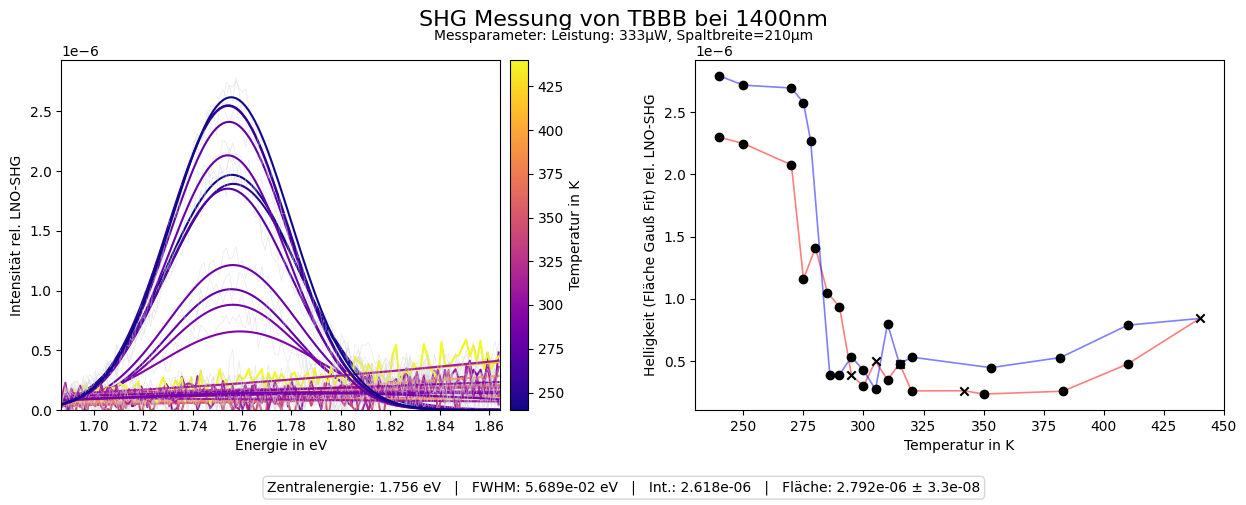

In [62]:
NLO_plot(
    middle_value=700,
    difference=35,
    filepath='2025-05-22 TBBB/1400nm/0.333mW_Spalt210um/*.asc',
    suptitle='SHG Messung von TBBB bei 1400nm',
    filename_prefix='TBBB_SHG_noErrorbar',
    show_errorbars=False
)

Maximale Fläche (unnormiert) der hellsten Messung: 4.3211775145533629e+07
Maximale Intensität (unnormiert) der hellsten Messung: 5.7614813716172898e+08


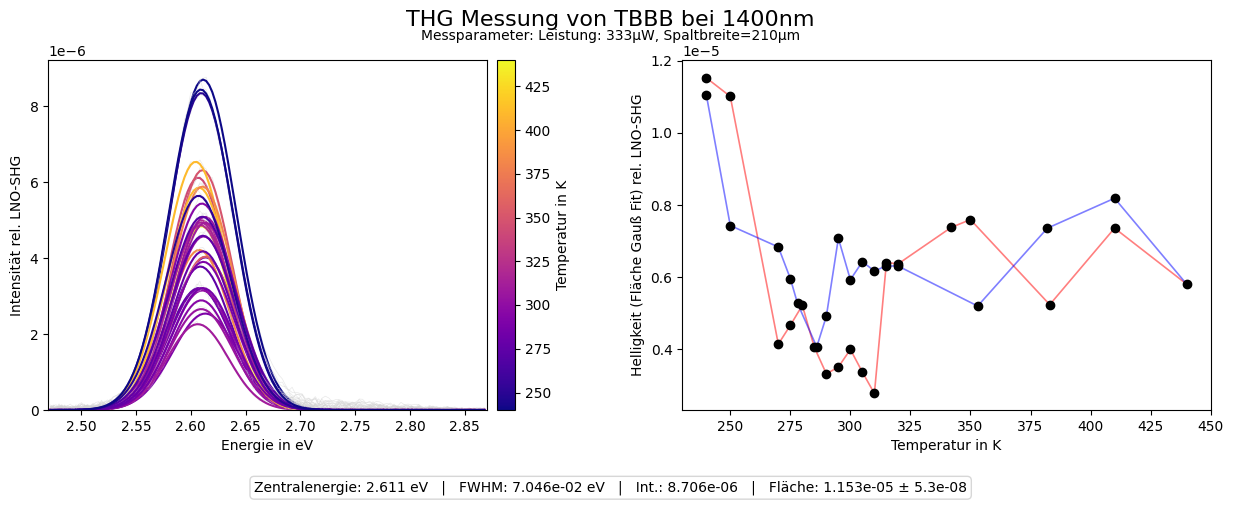

In [63]:
NLO_plot(
    middle_value=467,
    difference=35,
    filepath='2025-05-22 TBBB/1400nm/0.333mW_Spalt210um/*.asc',
    suptitle='THG Messung von TBBB bei 1400nm',
    filename_prefix='TBBB_THG',
)

## TCBC

Maximale Fläche (unnormiert) der hellsten Messung: 2.7275524847579718e+08
Maximale Intensität (unnormiert) der hellsten Messung: 4.5588114873347025e+09


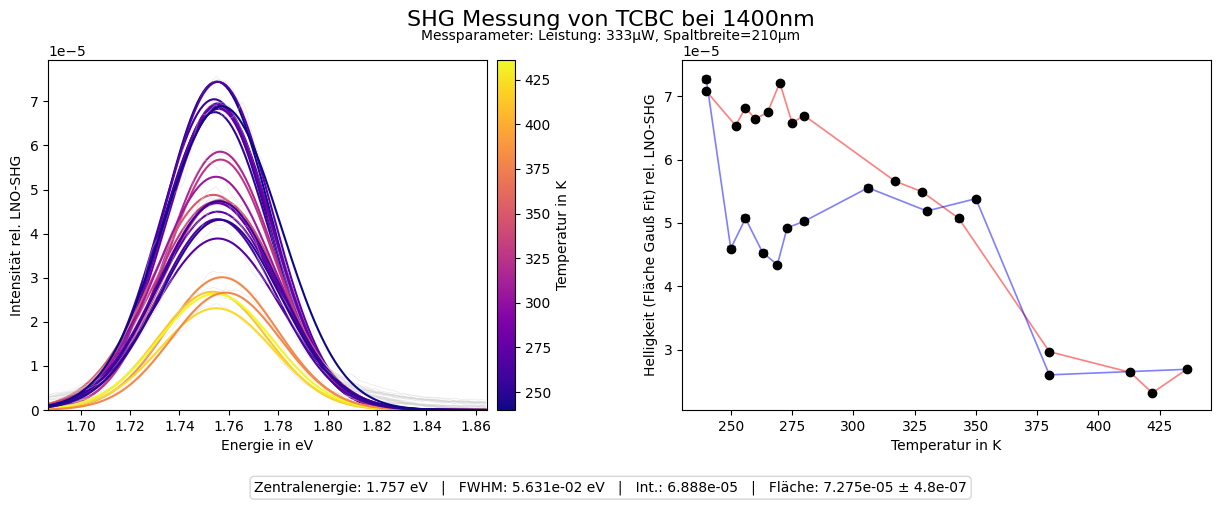

In [64]:
NLO_plot(
    middle_value=700,
    difference=35,
    filepath='2025-05-23 TCBC/1400nm/0.333mW_Spalt210um/*.asc',
    suptitle='SHG Messung von TCBC bei 1400nm',
    filename_prefix='TCBC_SHG'
)

Maximale Fläche (unnormiert) der hellsten Messung: 4.7203218376096152e+07
Maximale Intensität (unnormiert) der hellsten Messung: 6.1807786897993028e+08


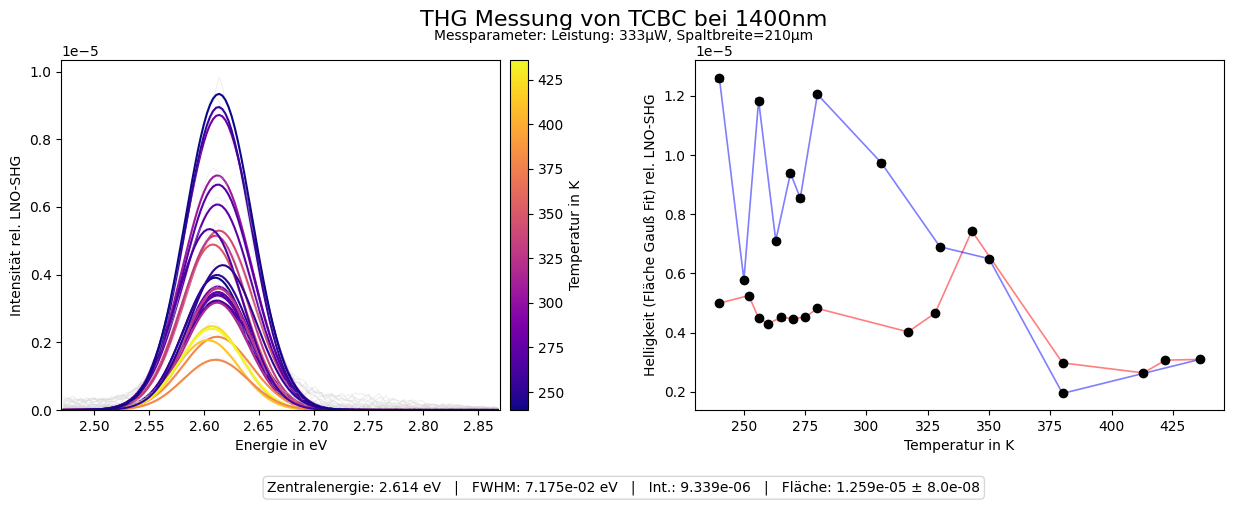

In [65]:
NLO_plot(
    middle_value=467,
    difference=35,
    filepath='2025-05-23 TCBC/1400nm/0.333mW_Spalt210um/*.asc',
    suptitle='THG Messung von TCBC bei 1400nm',
    filename_prefix='TCBC_THG'
)

## LNO

#### Vergleichsmessung

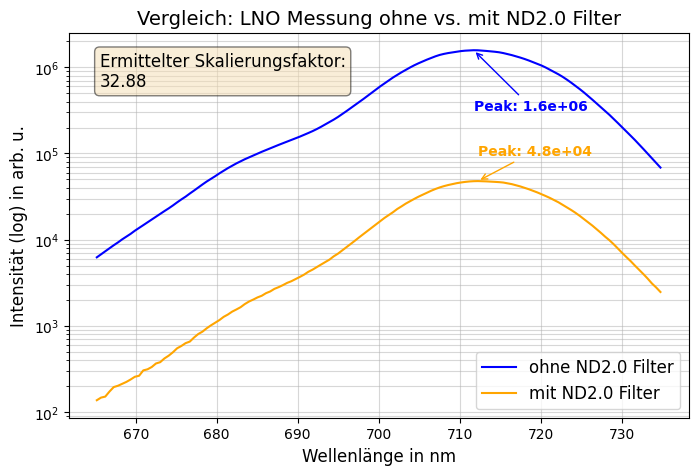

Skalierungsfaktor (ohne ND2.0 / mit ND2.0): 32.88


In [107]:
# Definiere den Wellenlängenbereich wie bei LNO SHG
x_range = (700 - 35, 700 + 35) # anpassen falls verändert!

# Lade die Vergleichsmessungen "mit" und "ohne" ND2.0:
files_ohne = glob.glob('2025-05-23 LNO/1400nm/0.333mW_Spalt210um/Vergleichsmessung ND2.0/ohne*.asc')
files_mit = glob.glob('2025-05-23 LNO/1400nm/0.333mW_Spalt210um/Vergleichsmessung ND2.0/mit*.asc')

# Wähle jeweils die erste Datei (ggf. anpassen, falls mehrere vorhanden)
file_ohne = files_ohne[0]
file_mit = files_mit[0]

# Lade die Daten
freqs_ohne, intensities_ohne = dat2array(file_ohne)
freqs_mit, intensities_mit = dat2array(file_mit)

# Filtere den Bereich wie bei x_range
filtered_data_ohne = [(fr, i) for fr, i in zip(freqs_ohne, intensities_ohne) if x_range[0] <= fr <= x_range[1]]
filtered_data_mit = [(fr, i) for fr, i in zip(freqs_mit, intensities_mit) if x_range[0] <= fr <= x_range[1]]

filtered_freqs_ohne, filtered_intensities_ohne = zip(*filtered_data_ohne) if filtered_data_ohne else ([], [])
filtered_freqs_mit, filtered_intensities_mit = zip(*filtered_data_mit) if filtered_data_mit else ([], [])

# Plotten
fig, ax0 = plt.subplots(figsize=(8, 5))
ax0.plot(filtered_freqs_ohne, filtered_intensities_ohne, label='ohne ND2.0 Filter', color='blue')
ax0.plot(filtered_freqs_mit, filtered_intensities_mit, label='mit ND2.0 Filter', color='orange')

ax0.set_title('Vergleich: LNO Messung ohne vs. mit ND2.0 Filter', fontsize=14)
ax0.set_xlabel('Wellenlänge in nm', fontsize=12)
ax0.set_ylabel('Intensität (log) in arb. u.', fontsize=12)
ax0.set_yscale('log')
ax0.legend(fontsize=12)
ax0.grid(True, which="both", ls="-", alpha=0.5)

peak_ohne = max(filtered_intensities_ohne)
peak_mit = max(filtered_intensities_mit)
peak_ohne_x = filtered_freqs_ohne[filtered_intensities_ohne.index(peak_ohne)]
peak_mit_x = filtered_freqs_mit[filtered_intensities_mit.index(peak_mit)]

# Berechne den Skalierungsfaktor
skalierungsfaktor = peak_ohne / peak_mit

ax0.annotate(f'Peak: {peak_ohne:.1e}', xy=(peak_ohne_x, peak_ohne), xytext=(peak_ohne_x, peak_ohne*0.2),
             arrowprops=dict(arrowstyle='->', color='blue'), color='blue', fontsize=10, fontweight='bold')
ax0.annotate(f'Peak: {peak_mit:.1e}', xy=(peak_mit_x, peak_mit), xytext=(peak_mit_x, peak_mit*2),
             arrowprops=dict(arrowstyle='->', color='orange'), color='orange', fontsize=10, fontweight='bold')

# Faktor deutlich im Plot anzeigen
textstr = f'Ermittelter Skalierungsfaktor:\n{skalierungsfaktor:.2f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax0.text(0.05, 0.95, textstr, transform=ax0.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

# plt.tight_layout()
plt.show()
fig.savefig('ND2-Skalierung.pdf', dpi=600, bbox_inches='tight')

print(f"Skalierungsfaktor (ohne ND2.0 / mit ND2.0): {skalierungsfaktor:.2f}")

### SHG

Maximale Fläche (unnormiert) der hellsten Messung: 3.7490887329303589e+12
Maximale Intensität (unnormiert) der hellsten Messung: 6.6181976472945719e+13


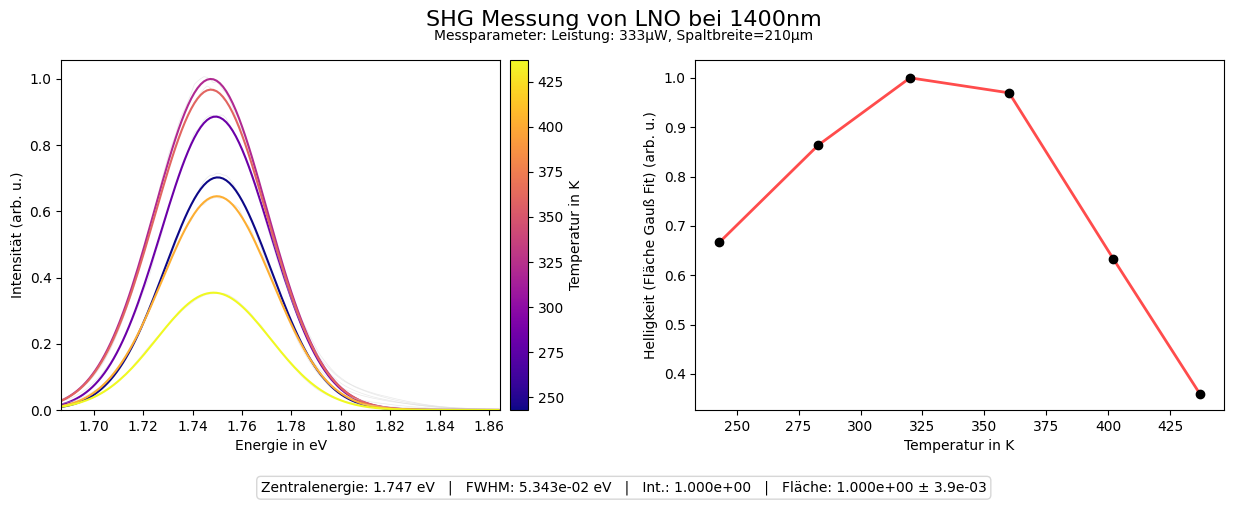

In [67]:
NLO_plot(
    middle_value=700,
    difference=35,
    filepath='2025-05-23 LNO/1400nm/0.333mW_Spalt210um/*.asc',
    suptitle='SHG Messung von LNO bei 1400nm',
    filename_prefix='LNO_SHG',
    reference=True
)

### THG

Maximale Fläche (unnormiert) der hellsten Messung: 1.0449557816307251e+09
Maximale Intensität (unnormiert) der hellsten Messung: 1.3942079736818483e+10


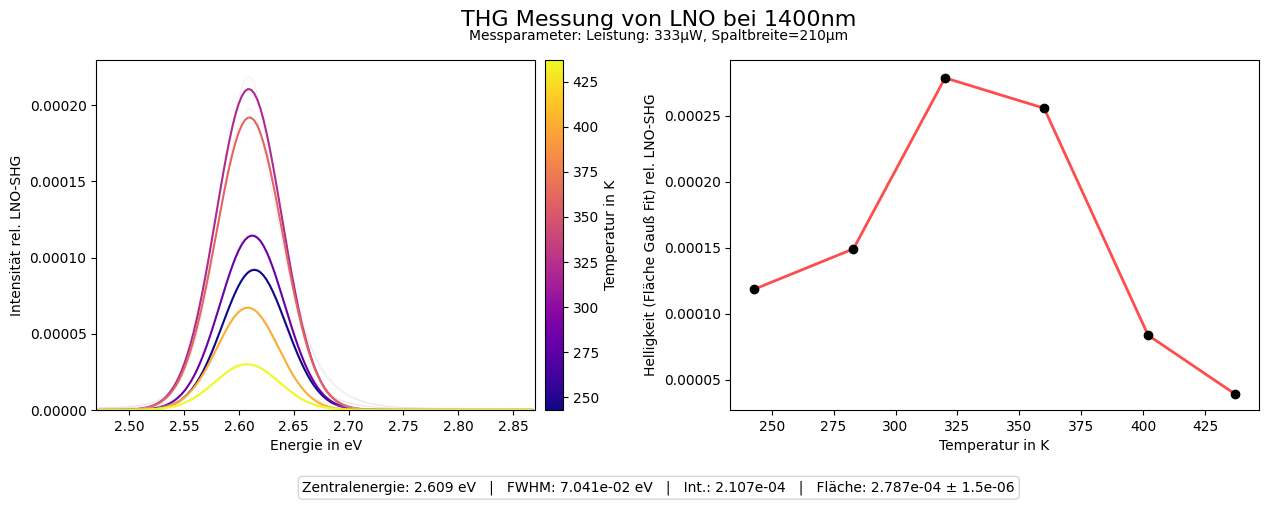

In [93]:
NLO_plot(
    middle_value=467,
    difference=35,
    filepath='2025-05-23 LNO/1400nm/0.333mW_Spalt210um/*.asc',
    suptitle='THG Messung von LNO bei 1400nm',
    filename_prefix='LNO_THG'
)

## TIBI

### SHG

Maximale Fläche (unnormiert) der hellsten Messung: 6.7143405909607100e+08
Maximale Intensität (unnormiert) der hellsten Messung: 9.7393162943605690e+09


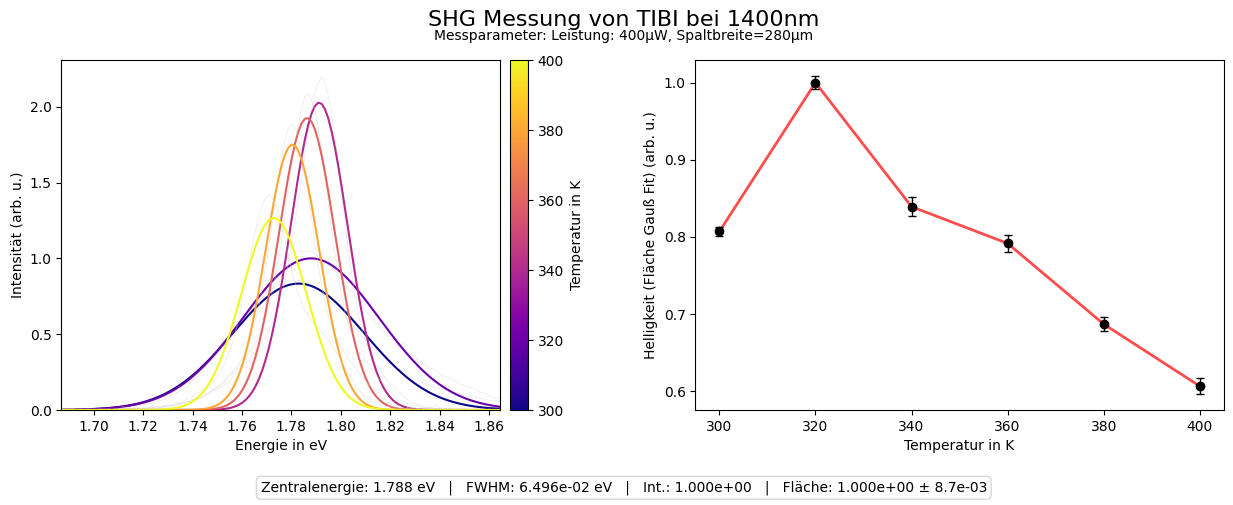

In [92]:
NLO_plot(
    middle_value=700,
    difference=35,
    filepath='TIBI_400uW_1400nm/*.asc',
    suptitle='SHG Messung von TIBI bei 1400nm',
    filename_prefix='TIBI_SHG',
    power="400µW",
    slit_width="280µm",
    compare=False,
    reference=False,
    normalisationfactor=6.7143405909607100e+08,
    norm_intensitaet=9.7393162943605690e+09,
)

### THG

Maximale Fläche (unnormiert) der hellsten Messung: 3.7206097359220743e+07
Maximale Intensität (unnormiert) der hellsten Messung: -7.8485786621733122e+09


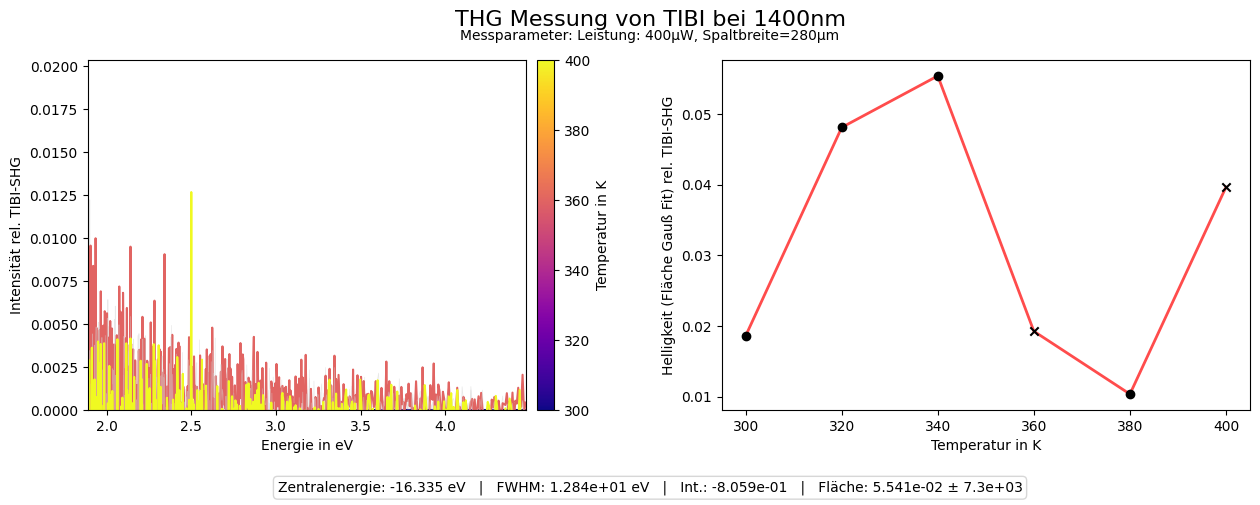

In [91]:
NLO_plot(
    middle_value=467,
    difference=190,
    filepath='TIBI_400uW_1400nm/*.asc',
    suptitle='THG Messung von TIBI bei 1400nm',
    filename_prefix='TIBI_THG_noErrorbar',
    power="400µW",
    slit_width="280µm",
    compare=True,
    normalisationfactor=6.7143405906491041e+08,
    norm_intensitaet=9.7393162937730503e+09,
    refmeas="TIBI-SHG",
    show_errorbars=False
)

## TISI

### SHG

Maximale Fläche (unnormiert) der hellsten Messung: 4.1730454417941847e+09
Maximale Intensität (unnormiert) der hellsten Messung: 7.8205974137625458e+10


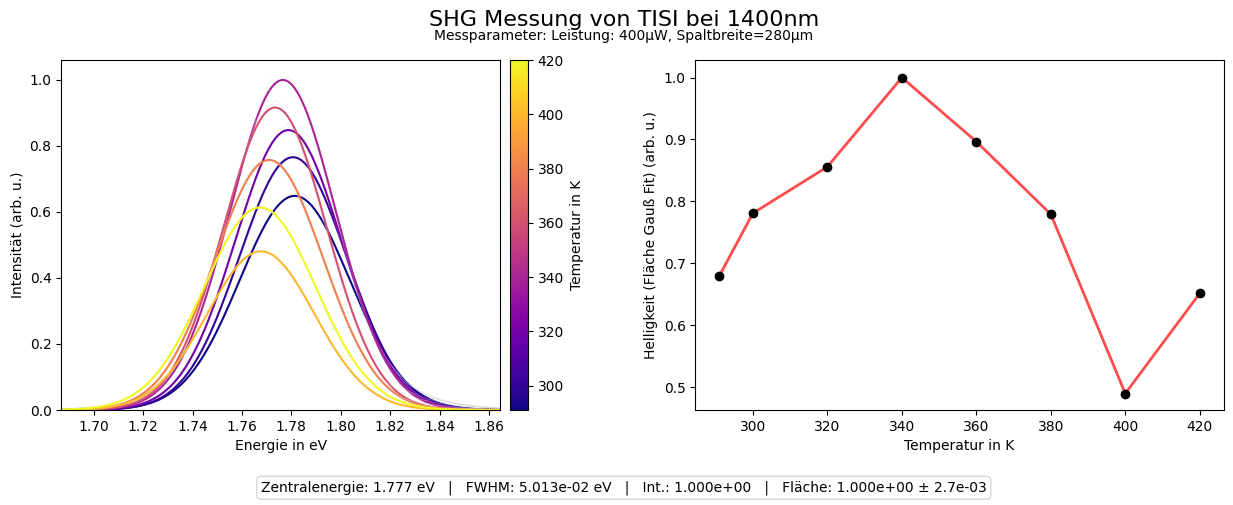

In [100]:
NLO_plot(
    middle_value=700,
    difference=35,
    filepath='TISI_400uW_1400nm/*.asc',
    suptitle='SHG Messung von TISI bei 1400nm',
    filename_prefix='TISI_SHG',
    power="400µW",
    slit_width="280µm",
    compare=False,
    reference=False,
    normalisationfactor=4.1730454417941847e+09,
    norm_intensitaet=7.8205974137625458e+10
)

Vergleichsmessung (reproduktivität:)

Maximale Fläche (unnormiert) der hellsten Messung: 2.3234362914695725e+09
Maximale Intensität (unnormiert) der hellsten Messung: 9.7906818154833618e+10


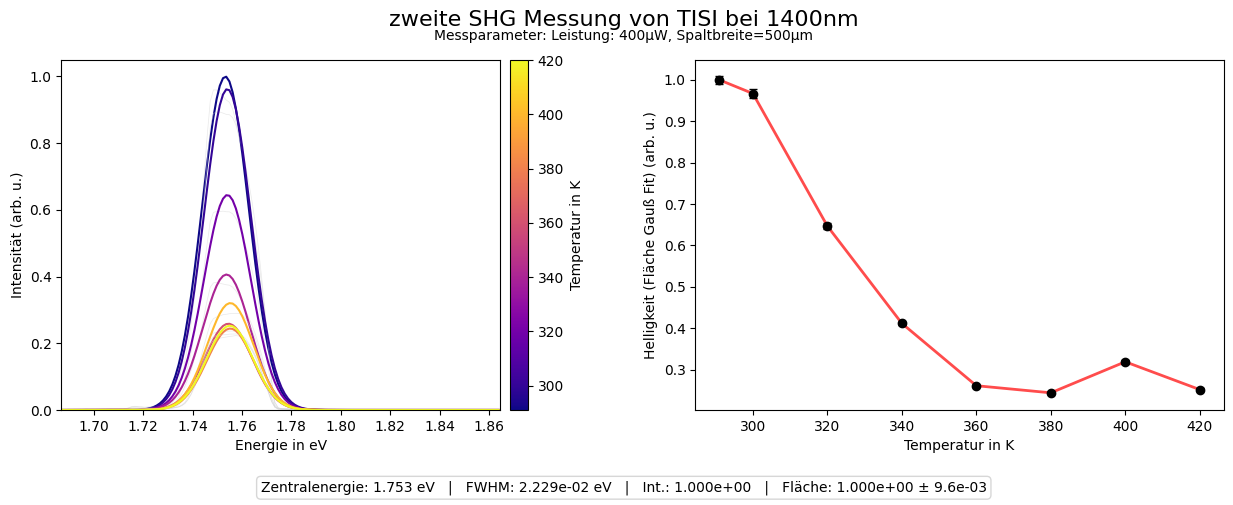

In [106]:
NLO_plot(
    middle_value=700,
    difference=35,
    filepath='TISI_400uW_1400nmm/*.asc',
    suptitle='zweite SHG Messung von TISI bei 1400nm',
    filename_prefix='TISI_SHG_reproduction',
    power="400µW",
    slit_width="500µm",
    compare=False,
    reference=False,
    normalisationfactor=2.3234362914695725e+09,
    norm_intensitaet=9.7906818154833618e+10
)

### THG

Maximale Fläche (unnormiert) der hellsten Messung: 3.2116164198759556e+07
Maximale Intensität (unnormiert) der hellsten Messung: 1.6168114967745182e+08


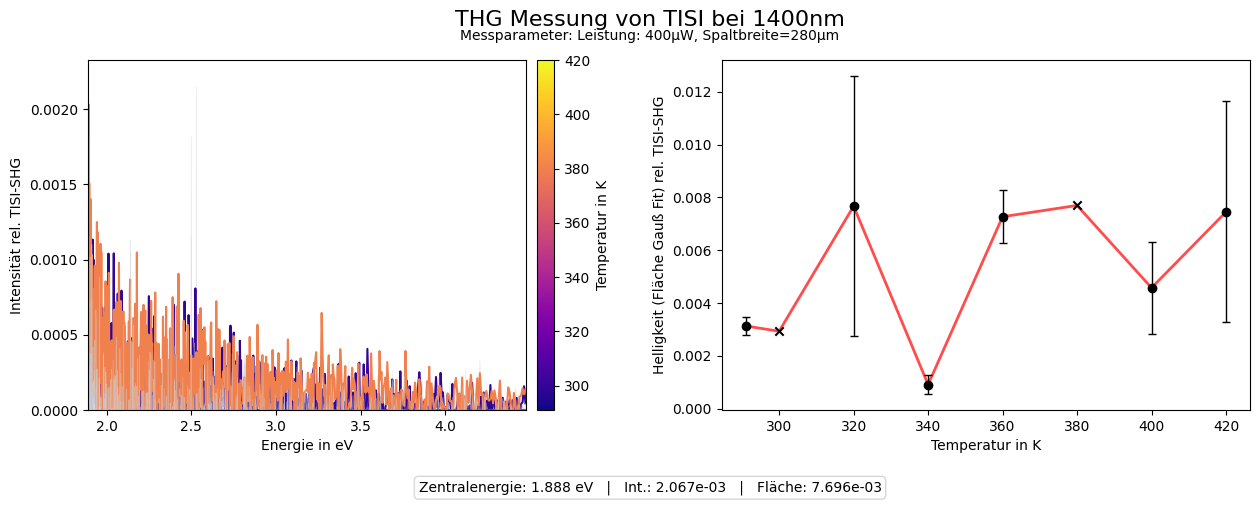

In [102]:
NLO_plot(
    middle_value=467,
    difference=190,
    filepath='TISI_400uW_1400nm/*.asc',
    suptitle='THG Messung von TISI bei 1400nm',
    filename_prefix='TISI_THG',
    power="400µW",
    slit_width="280µm",
    compare=True,
    normalisationfactor=4.1730454418659124e+09,
    norm_intensitaet=7.8205974134100433e+10,
    refmeas="TISI-SHG"
)